In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L

In [2]:
class Encoder(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(img_size * img_size, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)


class Decoder(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, img_size * img_size))

    def forward(self, x):
        return self.l1(x)

In [3]:
import pytorch_lightning as L
import torch
import torch.nn.functional as F

class LitAutoEncoder(L.LightningModule):
    def __init__(self, img_size=28, learning_rate=1e-3):
        super().__init__()
        self.encoder = Encoder(img_size)
        self.decoder = Decoder(img_size)

        self.save_hyperparameters() 

    def forward(self, x):
        # Forward pass
        x = x.view(x.size(0), -1)  
        z = self.encoder(x)         
        x_hat = self.decoder(z)     
        return x_hat 

    def training_step(self, batch, batch_idx):
        # Training loop
        x, _ = batch
        x_hat = self(x)  
        loss = F.mse_loss(x_hat, x.view(x.size(0), -1)) 
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Validation loop
        x, _ = batch
        x_hat = self(x) 
        val_loss = F.mse_loss(x_hat, x.view(x.size(0), -1))  
        self.log("val_loss", val_loss) 
        return val_loss
    
    def test_step(self, batch, batch_idx):
        # Test loop
        x, _ = batch
        x_hat = self(x)  
        test_loss = F.mse_loss(x_hat, x.view(x.size(0), -1))  
        self.log("test_loss", test_loss)  
        return test_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

In [4]:
train_set = MNIST("data/mnist", download=True, transform=transforms.ToTensor())
test_set = MNIST("data/mnist", download=True, train=False, transform=transforms.ToTensor())

# use 20% of training data for validation
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',         
    dirpath='ckpts/autoencoder',  
    filename='autoencoder-{epoch:02d}-{val_loss:.2f}',  # Custom filename
    save_top_k=2,               # Save the top 2 models
    mode='min',                  # Save models with the minimum validation loss
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Track the validation loss
    min_delta=0.001,     # Minimum change in the loss to be considered as an improvement
    patience=5,          # Wait for 5 epochs with no improvement
    verbose=True,        # Output logs when early stopping is triggered
    mode="min"           # Stop when the loss stops decreasing
)


num_epochs = 100
check_val_every_n_epoch = 5

autoencoder = LitAutoEncoder(img_size=28, learning_rate=1e-3)
autoencoder.to(device)

trainer = L.Trainer(
    default_root_dir="ckpts/autoencoder",
    devices=1,
    accelerator='mps',
    max_epochs=num_epochs,
    check_val_every_n_epoch=check_val_every_n_epoch,
    callbacks=[checkpoint_callback, early_stop_callback]   
)


trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/pytorch-lightning/ckpts/autoencoder exists and

/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 1500/1500 [00:08<00:00, 187.33it/s, v_num=2]

Metric val_loss improved. New best score: 0.040


Epoch 9: 100%|██████████| 1500/1500 [00:08<00:00, 178.55it/s, v_num=2]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.039


Epoch 24: 100%|██████████| 1500/1500 [00:08<00:00, 182.61it/s, v_num=2]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.038


Epoch 49: 100%|██████████| 1500/1500 [00:07<00:00, 195.75it/s, v_num=2]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.038. Signaling Trainer to stop.


Epoch 49: 100%|██████████| 1500/1500 [00:08<00:00, 167.50it/s, v_num=2]


In [6]:
trainer.test(model=autoencoder, dataloaders=test_loader)

/Users/temiloluw.adeoti/codes-and-scripts/exploration/learn-by-doing/lbd-env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 313/313 [00:00<00:00, 385.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.03682464361190796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03682464361190796}]

In [7]:
checkpoint = torch.load("ckpts/autoencoder/autoencoder-epoch=14-val_loss=0.04.ckpt", map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])

{'img_size': 28, 'learning_rate': 0.001}


/var/folders/qt/1k8y1yc54bg30x40jyd2gt2c0000gn/T/ipykernel_81959/500317199.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("ckpts/autoencoder/aut

In [8]:
checkpoint["state_dict"]

OrderedDict([('encoder.l1.0.weight',
              tensor([[ 0.0080, -0.0024,  0.0329,  ...,  0.0003, -0.0137, -0.0347],
                      [-0.0184,  0.0287,  0.0036,  ...,  0.0185, -0.0243, -0.0154],
                      [ 0.0117, -0.0032,  0.0070,  ..., -0.0070,  0.0100, -0.0144],
                      ...,
                      [-0.0074,  0.0174, -0.0316,  ...,  0.0011,  0.0148, -0.0254],
                      [-0.0189,  0.0047,  0.0343,  ..., -0.0215,  0.0248,  0.0021],
                      [-0.0188,  0.0063,  0.0291,  ...,  0.0188, -0.0011,  0.0200]])),
             ('encoder.l1.0.bias',
              tensor([ 0.0270, -0.0202, -0.0019, -0.0378,  0.9027, -0.0158,  0.9060,  0.0333,
                       0.5379,  0.0182,  0.8200,  0.1632, -0.1237, -0.3337, -0.0290,  0.1624,
                       0.4797,  0.1056, -0.0394,  0.0376, -0.0641,  0.1250,  0.7600,  0.0216,
                      -0.0448, -0.0319, -0.0194,  0.0116,  0.2616,  0.0245, -0.0146,  0.0155,
                  

In [9]:
loaded_autoencoder = LitAutoEncoder.load_from_checkpoint("ckpts/autoencoder/autoencoder-epoch=19-val_loss=0.04.ckpt")
print(f"learning rate: {loaded_autoencoder.hparams.learning_rate}")
print(f"img size: {loaded_autoencoder.hparams.img_size}")
print(f"Model: {loaded_autoencoder}")

learning rate: 0.001
img size: 28
Model: LitAutoEncoder(
  (encoder): Encoder(
    (l1): Sequential(
      (0): Linear(in_features=784, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (l1): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=784, bias=True)
    )
  )
)


In [10]:
import matplotlib.pyplot as plt

def visualize_reconstructed_images(autoencoder, data_loader, n_images=6, device='cpu', img_size=(28, 28)):
    """
    Visualizes original and reconstructed images from the autoencoder model.

    Parameters:
    - autoencoder: The trained autoencoder model.
    - data_loader: DataLoader for the dataset (test/validation).
    - n_images: Number of images to visualize (default: 6).
    - device: The device where the model and data reside ('cpu' or 'cuda' or 'mps').
    - img_size: The size of the images to reshape for visualization (default: (28, 28) for MNIST).
    """

    # Set the model to evaluation mode
    autoencoder.eval()

    # Get a batch of data from the data loader
    data_iter = iter(data_loader)
    test_batch, _ = next(data_iter)

    # Move the batch to the specified device
    test_batch = test_batch.to(device)

    # Forward pass through the autoencoder
    with torch.no_grad():
        reconstructed_batch = autoencoder(test_batch)

    # Move the tensors back to CPU for visualization
    test_batch = test_batch.cpu()
    reconstructed_batch = reconstructed_batch.cpu()

    # Un-normalize function for images
    def unnormalize_and_reshape(tensor, size):
        tensor = tensor.view(-1, *size)
        return tensor * 0.5 + 0.5  # Assuming normalization with mean=0.5, std=0.5

    # Un-normalize original and reconstructed images
    test_batch = unnormalize_and_reshape(test_batch, img_size)
    reconstructed_batch = unnormalize_and_reshape(reconstructed_batch, img_size)

    # Plot original and reconstructed images
    plt.figure(figsize=(12, 4))

    for i in range(n_images):
        # Original images
        plt.subplot(2, n_images, i + 1)
        plt.imshow(test_batch[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_batch[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()


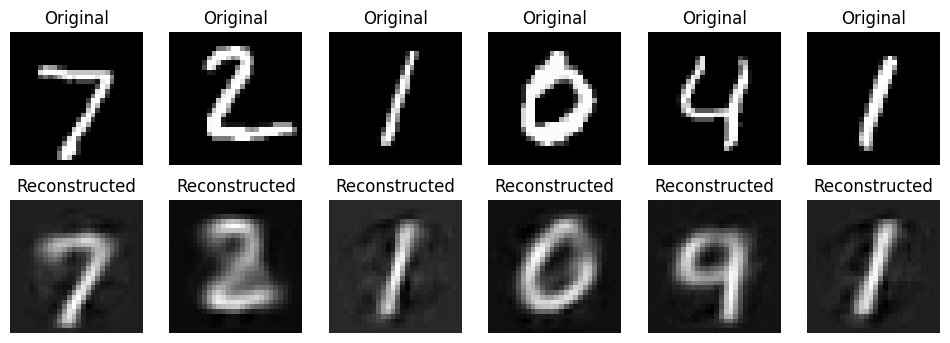

In [11]:
visualize_reconstructed_images(loaded_autoencoder, test_loader, n_images=6, device="mps")